In [2]:
import numpy
import math
import pandas
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


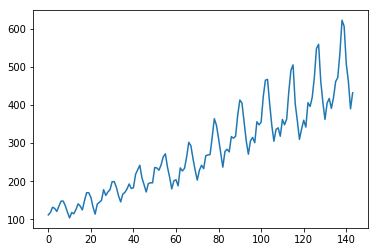

In [3]:
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

The downloaded dataset also has footer information that we can exclude with the skipfooter argument to pandas.read_csv() set to 3 for the 3 footer lines.

## We phrase the problem as regression problem.  
That is, given the number of passengers (in units of thousands) this month, what is the number of passengers next month? 

### We can write a simple function to convert out single column of data into a two-column dataset: the first column containing this month's (t) passenger count and the second column containing next month's (t+1) passenger counter, to be predicted. 


In [5]:
numpy.random.seed(7)  # esnure it is reproducible. 

In [7]:
dataset = dataset.values
dataset = dataset.astype('float32')
dataset

array([[ 112.],
       [ 118.],
       [ 132.],
       [ 129.],
       [ 121.],
       [ 135.],
       [ 148.],
       [ 148.],
       [ 136.],
       [ 119.],
       [ 104.],
       [ 118.],
       [ 115.],
       [ 126.],
       [ 141.],
       [ 135.],
       [ 125.],
       [ 149.],
       [ 170.],
       [ 170.],
       [ 158.],
       [ 133.],
       [ 114.],
       [ 140.],
       [ 145.],
       [ 150.],
       [ 178.],
       [ 163.],
       [ 172.],
       [ 178.],
       [ 199.],
       [ 199.],
       [ 184.],
       [ 162.],
       [ 146.],
       [ 166.],
       [ 171.],
       [ 180.],
       [ 193.],
       [ 181.],
       [ 183.],
       [ 218.],
       [ 230.],
       [ 242.],
       [ 209.],
       [ 191.],
       [ 172.],
       [ 194.],
       [ 196.],
       [ 196.],
       [ 236.],
       [ 235.],
       [ 229.],
       [ 243.],
       [ 264.],
       [ 272.],
       [ 237.],
       [ 211.],
       [ 180.],
       [ 201.],
       [ 204.],
       [ 188.],
       [

LSTMs are sensitive to thescale of the input data, specifically when the sigmoid (default) or tanh activation functions are used. It can be a good practice to rescale the data to the range of 0-to-1.

you can save the MinMaxScaler used to scale the training data and use it later to scale new input data and in turn descale predictions. The call is **scaler.inverse_transform()** from memory.

In [8]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[ 0.01544401],
       [ 0.02702703],
       [ 0.05405405],
       [ 0.04826255],
       [ 0.03281853],
       [ 0.05984557],
       [ 0.08494207],
       [ 0.08494207],
       [ 0.06177607],
       [ 0.02895753],
       [ 0.        ],
       [ 0.02702703],
       [ 0.02123553],
       [ 0.04247104],
       [ 0.07142857],
       [ 0.05984557],
       [ 0.04054055],
       [ 0.08687258],
       [ 0.12741312],
       [ 0.12741312],
       [ 0.10424709],
       [ 0.05598456],
       [ 0.01930502],
       [ 0.06949806],
       [ 0.07915059],
       [ 0.08880308],
       [ 0.14285713],
       [ 0.11389962],
       [ 0.13127413],
       [ 0.14285713],
       [ 0.18339768],
       [ 0.18339768],
       [ 0.15444016],
       [ 0.11196911],
       [ 0.08108109],
       [ 0.1196911 ],
       [ 0.12934363],
       [ 0.14671814],
       [ 0.17181468],
       [ 0.14864865],
       [ 0.15250966],
       [ 0.22007722],
       [ 0.24324325],
       [ 0.26640925],
       [ 0.2027027 ],
       [ 0

Set up dataset for both training and corss validation. 
With time series data, the sequence of values is important. Asimple method that we can use is to split the ordered dataset into train and test dataset. The code below calculates the index of the split point and separates the data into the training datasets with 67% of the observations that we can use to train our model, leaving the remaining 33% for testing the model. 

In [9]:
# split into train and test sets
train_size = int(len(dataset)*0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), train_size, len(test), test_size)

96 96 48 48


### define a function to create a new dataset, as described above
The function takes two arguments: the **dataset**, which is a Numpy array that we want to convert into a dataset, and the **look_back**, which is the number of previous time steps to use as input variables to predict the next time period - in this case defaulted to 1. 

In [13]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)  # note, after process, dataX has 1 more dim than dataY
        dataY.append(dataset[i+look_back, 0])  # for example, dataX add i(th), dataY add (i+1)(th)
    return numpy.array(dataX), numpy.array(dataY) 

In [17]:
#Let's do qucik check on unnormalized form
d = pandas.read_csv('international-airline-passengers.csv', usecols=[1], engine='python', skipfooter=3)
d = d.values.astype('float32')
X, Y = create_dataset(d)
print("X       Y")
for i in range(5):
    print(X[i][0], Y[i])

X       Y
112.0 118.0
118.0 132.0
132.0 129.0
129.0 121.0
121.0 135.0


In [18]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

### The LSTM network expects the input data(X) to be provided with a specific array structure in the form of : *[samples, time_steps, features]*
currently our data is in the form: **[samples, features]** and we are framing the problem as one time step for each sample. We can transform the prepared train and test input data into the expected structure using **numpy.reshape()** as follows:

In [20]:
# reshape input to be [samples, time_steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

## we are now ready to design and fit our LSTM network for this problem.
The network has a visible layer with 1 input, a hidden layer with 4 LSTM blocks or neurons, and an ouptut layer that makes a single value prediction. The default sigmoid activation function is used for the LSTM blocks. the network is trained for 100 epochs and a batch size of 1 is used. 

#### More neurons means more representational capacity at that layer. More layers means more opportunity to abstract hierarchical features.
#### The number of neurons (LSTM call them blocks) and layers to use is a matter of trial and error (tuning).

In [22]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_dim=look_back))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_2 (LSTM)                    (None, 4)             96          lstm_input_2[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             5           lstm_2[0][0]                     
Total params: 101
Trainable params: 101
Non-trainable params: 0
____________________________________________________________________________________________________


In [23]:
model.fit(trainX, trainY, nb_epoch=100, batch_size=1, verbose=2)

Epoch 1/100
0s - loss: 0.0390
Epoch 2/100
0s - loss: 0.0182
Epoch 3/100
0s - loss: 0.0129
Epoch 4/100
0s - loss: 0.0113
Epoch 5/100
0s - loss: 0.0102
Epoch 6/100
0s - loss: 0.0092
Epoch 7/100
0s - loss: 0.0081
Epoch 8/100
0s - loss: 0.0071
Epoch 9/100
0s - loss: 0.0062
Epoch 10/100
0s - loss: 0.0053
Epoch 11/100
0s - loss: 0.0045
Epoch 12/100
0s - loss: 0.0039
Epoch 13/100
0s - loss: 0.0033
Epoch 14/100
0s - loss: 0.0029
Epoch 15/100
0s - loss: 0.0025
Epoch 16/100
0s - loss: 0.0024
Epoch 17/100
0s - loss: 0.0022
Epoch 18/100
0s - loss: 0.0021
Epoch 19/100
0s - loss: 0.0020
Epoch 20/100
0s - loss: 0.0020
Epoch 21/100
0s - loss: 0.0020
Epoch 22/100
0s - loss: 0.0020
Epoch 23/100
0s - loss: 0.0020
Epoch 24/100
0s - loss: 0.0019
Epoch 25/100
0s - loss: 0.0020
Epoch 26/100
0s - loss: 0.0020
Epoch 27/100
0s - loss: 0.0020
Epoch 28/100
0s - loss: 0.0020
Epoch 29/100
0s - loss: 0.0020
Epoch 30/100
0s - loss: 0.0020
Epoch 31/100
0s - loss: 0.0019
Epoch 32/100
0s - loss: 0.0020
Epoch 33/100
0s -

### Estimate the performance of the model
Once the model is fit, we can estimate the performance of model on the train and test datasets. This will give us a point of comparison for new models. 
Note that we invert the predictions before calculating error scores to ensure the performance is reported in the same units as the original data(thousands of passergers per month)

In [24]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.19 RMSE
Test Score: 50.57 RMSE


Finally, we can generate predictions using the model for both the train and test dataset to get a visual indication of the skill of the model.

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.

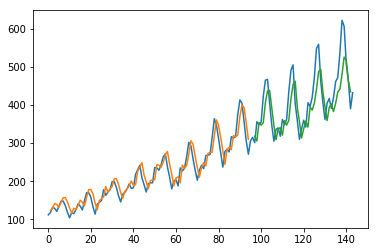

In [25]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()